In [ ]:
# !pip install torch datasets transformers numpy pandas scipy matplotlib


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy.stats import spearmanr, pearsonr
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import json
import time
import random
import os
from joblib import Parallel, delayed
import multiprocessing

In [2]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
multiprocessing.set_start_method("spawn", force=True)

In [4]:
device = 'cpu'

In [5]:
# torch.cuda.empty_cache()

In [6]:
# GPU not really needed

# if torch.cuda.is_available():
#     print("CUDA is available!")
#     device = torch.device("cuda")
# else:
#     print("CUDA is not available. Running on CPU.")
#     device = torch.device("cpu")

In [7]:
# load a wikipedia dataset
dataset = load_dataset("tcltcl/inuit-wikipedia", trust_remote_code=True)


In [8]:
# load a small pretrained GPT model and tokenizer
model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# use the eos token as padding
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))
model = model.to(device)
model.eval()


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [9]:
print("Tokenizer vocab size:", len(tokenizer))
print("Model vocab size:", model.config.vocab_size)


Tokenizer vocab size: 50257
Model vocab size: 50257


In [10]:
dataset.keys()

dict_keys(['train'])

In [11]:
max_length = 1024  # model's max length
stride = 512  # set stride between overlapping chunks of text tokens
context_buffer = 32  # number of tokens from left-side context each chunk
chunked_tokens = []  # tokenized chunks
center_positions = []  # central part of each chunk
# model config token padding
model.config.pad_token_id = tokenizer.pad_token_id
max_input_length = model.config.n_positions  # 1024 for distilgpt2
# tokenize data to have consistent sequence length
for item in dataset["train"]:
    # get text
    text = item["text"]
    # tokenize as 1D list (no batches)
    tokens = tokenizer(text, return_tensors="pt", truncation=False)["input_ids"].squeeze(0)
    token_length = len(tokens)

    # make overlapping sliding window chunks of text
    for i in range(0, token_length, stride):
        # include left context in window, but stay in bounds
        start = max(i - context_buffer, 0)
        end = min(start + max_input_length, token_length)  # end of chunk, within max 
        
        token_chunk = tokens[start:end]  # get chunk slice

        # double check no chunk exceeds model limit
        assert len(token_chunk) <= max_input_length, f"chunk too long: {len(token_chunk)}"

        chunked_tokens.append(token_chunk)
        center_start = i - start  # get center tokens in chunk
        center_end = min(center_start + stride, len(token_chunk))
        center_positions.append((center_start, center_end))


Token indices sequence length is longer than the specified maximum sequence length for this model (3721 > 1024). Running this sequence through the model will result in indexing errors


In [12]:
tokenizer('inuit')

{'input_ids': [259, 5013], 'attention_mask': [1, 1]}

In [13]:
tokenizer.decode([259])

'in'

In [14]:
tokenizer.decode([5013])

'uit'

In [15]:
tokenizer('american')

{'input_ids': [2382, 7490], 'attention_mask': [1, 1]}

In [16]:
tokenizer.decode([2382])

'amer'

In [17]:
tokenizer.decode([7490])

'ican'

In [18]:
tokenizer('ced')

{'input_ids': [771], 'attention_mask': [1]}

In [19]:
tokenizer.decode([771])

'ced'

In [20]:
# get LLM hidden activations
def get_activations(tokenized_inputs, model, layer_idx=0, batch_size=16):
    all_activations = []
    for i in range(0, len(tokenized_inputs), batch_size):
        batch_tokens = tokenized_inputs[i:i+batch_size]
        # pad sequences
        batch_tokens = torch.nn.utils.rnn.pad_sequence(
            batch_tokens, batch_first=True, padding_value=tokenizer.pad_token_id
        )
        batch_tokens = batch_tokens.to(model.device)
        with torch.no_grad():
            outputs = model(input_ids=batch_tokens, output_hidden_states=True)
        act = outputs.hidden_states[layer_idx].cpu()  # get layer activations
        all_activations.append(act)
        # torch.cuda.empty_cache()
    return torch.cat(all_activations, dim=0)  # concat along sequence axis


In [21]:

# get middle layer activations
activations = get_activations(chunked_tokens, model, layer_idx=2)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


In [22]:
# set seeds for reproducibility
seed = 42  
random.seed(seed)

np.random.seed(seed)
torch.manual_seed(seed)

# if using GPU
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [23]:
# top k sparse autoencoder
# k determines number of latent activations to keep
class TopKSparseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, k):
        super().__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)
        self.k = k
    
    def forward(self, x):
        encoded = torch.relu(self.encoder(x))
        # select the top k activations
        topk_values, topk_indices = torch.topk(encoded, self.k, dim=-1)
        # mask where only top k values are 1, in the last dimension
        mask = torch.zeros_like(encoded).scatter_(-1, topk_indices, 1)
        # zero non top k activations
        sparse_encoded = encoded * mask 
        decoded = self.decoder(sparse_encoded)
        return decoded, sparse_encoded


In [24]:
# train SAE
input_dim = activations.shape[-1]  # layer activations size
expansion_factor = 4  # expand activations by this multiple 
hidden_dim = input_dim * expansion_factor  
k = 32  # top k activations to keep
sae = TopKSparseAutoencoder(input_dim, hidden_dim, k).to(device) 
# update sae parameters
optimizer = optim.Adam(sae.parameters(), lr=0.001)
criterion = nn.MSELoss()

def train_sae(sae, activations, epochs=200):
    activations = activations.to(device) 
    for epoch in range(epochs):
        optimizer.zero_grad()
        decoded, encoded = sae(activations)
        loss = criterion(decoded, activations)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

train_sae(sae, activations)

Epoch 0: Loss = 78.0950
Epoch 10: Loss = 70.7868
Epoch 20: Loss = 63.9022
Epoch 30: Loss = 55.4079
Epoch 40: Loss = 45.3439
Epoch 50: Loss = 34.0258
Epoch 60: Loss = 22.9256
Epoch 70: Loss = 14.0222
Epoch 80: Loss = 8.5029
Epoch 90: Loss = 6.0251
Epoch 100: Loss = 5.1004
Epoch 110: Loss = 4.5069
Epoch 120: Loss = 3.9158
Epoch 130: Loss = 3.3579
Epoch 140: Loss = 2.8870
Epoch 150: Loss = 2.4911
Epoch 160: Loss = 2.1540
Epoch 170: Loss = 1.8633
Epoch 180: Loss = 1.6112
Epoch 190: Loss = 1.3964


In [ ]:
"""
Epoch 0: Loss = 78.0950
Epoch 10: Loss = 70.7868
Epoch 20: Loss = 63.9022
Epoch 30: Loss = 55.4079
Epoch 40: Loss = 45.3439
Epoch 50: Loss = 34.0258
Epoch 60: Loss = 22.9256
Epoch 70: Loss = 14.0222
Epoch 80: Loss = 8.5029
Epoch 90: Loss = 6.0251
Epoch 100: Loss = 5.1004
Epoch 110: Loss = 4.5069
Epoch 120: Loss = 3.9158
Epoch 130: Loss = 3.3579
Epoch 140: Loss = 2.8870
Epoch 150: Loss = 2.4911
Epoch 160: Loss = 2.1540
Epoch 170: Loss = 1.8633
Epoch 180: Loss = 1.6112
Epoch 190: Loss = 1.3964
"""

In [25]:
# use trained SAE to get activation values
sae.eval() 
with torch.no_grad():
    _, sparse_encoded = sae(activations)  


In [26]:
# save npz file with tokens and SAE activations
np.savez_compressed("feature_activations_inuit.npz", 
                    tokens=np.array([tokens.tolist() for tokens in chunked_tokens], dtype=object),
                    features=sparse_encoded.cpu().numpy(),
                    center_positions=np.array(center_positions, dtype=object))  


In [27]:
# check activation values for a certain feature
data = np.load("feature_activations_inuit.npz", allow_pickle=True)
feature_activations = data["features"]  # shape: (136, 1024, 3072)

print(f"Feature 0 activation values: {feature_activations[:, :, 0].flatten()[:20]}")


Feature 0 activation values: [ 0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.       12.387683  7.579616
  0.        0.       10.001779  0.        0.       11.724559]


In [28]:
# get activation info
print(f"Max activation: {sparse_encoded.max().item()}")
print(f"Min activation: {sparse_encoded.min().item()}")
print(f"Mean activation: {sparse_encoded.mean().item()}")
print(f"Nonzero activations count: {(sparse_encoded != 0).sum().item()}")
print(f"Zero activations count:  {(sparse_encoded == 0).sum().item()}")

Max activation: 496.6434326171875
Min activation: 0.0
Mean activation: 0.2898789048194885
Nonzero activations count: 2359296
Zero activations count:  224133120


In [29]:
# check file size (though file could be checked in explorer)
file_size = os.path.getsize("feature_activations_inuit.npz") / (1024**2)  # MB
print(f"Feature activations file size: {file_size:.2f} MB")


Feature activations file size: 14.79 MB


In [30]:
print(f"SAE output shape: {sparse_encoded.shape}")  # Should be (batch, 1024, 3072)


SAE output shape: torch.Size([72, 1024, 3072])


In [31]:
sparse_encoded.shape

torch.Size([72, 1024, 3072])

In [32]:
activations.shape

torch.Size([72, 1024, 768])

In [33]:
# get mean top activations from words per feature
startt = time.perf_counter()
def process_entire_dataset_word(filename, tokenizer, feature_idx, top_n=10):

    data = np.load(filename, allow_pickle=True)
    tokens_list = data["tokens"]
    feature_activations = data["features"]
    center_positions = data["center_positions"]  

    word_activation_strength = {}  # activation sums
    word_counts = {}
    # monitor time
    print('Feature', feature_idx, 'Shape:', feature_activations.shape, time.perf_counter() - startt)

    # check if all values in a latent are 0 and set all to ("@@@@", 0.0) if so
    if np.all(feature_activations[:, :, feature_idx] == 0):
        return [("@@@@", 0.0)] * top_n
    
    # Loop through tokens and feature activations
    for tokens, activations in zip(tokens_list, feature_activations):
        tokens = torch.tensor(tokens, dtype=torch.long)
        activations = torch.tensor(activations, dtype=torch.float32)[:, feature_idx]  # get activations for the feature
        
        # convert tokens to words
        token_list = tokenizer.convert_ids_to_tokens(tokens.tolist())

        reconstructed_words = []
        current_word = ""
        current_activations = []
        score_fn = "mean"
        
        for token, activation in zip(token_list, activations):
            # continuation of current word (with or without '##')
            if token.startswith("##") or (current_word and not token.startswith("Ġ")):
                clean_token = token[2:] if token.startswith("##") else token
                current_word += clean_token
                current_activations.append(activation)
            else:
                # Attach 'uit' to previous word if part of a larger word like 'Inuit'
                if token == 'uit' and current_word:
                    current_word += token
                    current_activations.append(activation)
                else:
                    # new word starting
                    if current_word:
                        # compute activation score
                        score = np.mean(current_activations) if score_fn == "mean" else max(current_activations)
                        reconstructed_words.append((current_word, score))
                    current_word = token.lstrip("Ġ")  # remove GPT token prefix
                    current_activations = [activation]
    
        # catch last word 
        if current_word:
            score = np.mean(current_activations) if score_fn == "mean" else max(current_activations)
            reconstructed_words.append((current_word, score))

        # get mean activation per word 
        for word, score in reconstructed_words:
            if len(word) < 2 or not word.isascii():  # Skip short or non-ASCII words
                continue
            # add word if not seen before
            if word not in word_activation_strength:
                word_activation_strength[word] = 0
                word_counts[word] = 0
            # add activations
            word_activation_strength[word] += score
            word_counts[word] += 1

    # get mean activation per word across data
    avg_word_activations = {word: float(word_activation_strength[word] / word_counts[word]) 
                            for word in word_activation_strength}
    # sort words by mean activation, descending
    sorted_words = sorted(avg_word_activations.items(), key=lambda item: item[1], reverse=True)
    return sorted_words[:top_n]  # get the top n words with highest activations


In [34]:
# number of features in the sparse autoencoder
num_features = hidden_dim  

start_time = time.perf_counter()

# run in parallel across CPU cores
top_word_feat = Parallel(n_jobs=8)(
    delayed(process_entire_dataset_word)("feature_activations_inuit.npz", tokenizer, feature_idx, top_n=20)
    for feature_idx in range(num_features)
)

# convert to dict (Parallel returns a list)
top_word_feat_dict = {feature_idx: top_word_feat[feature_idx] for feature_idx in range(num_features)}

end_time = time.perf_counter()
print(f"Processing completed in {end_time - start_time:.2f} seconds")


Feature 0 Shape: (72, 1024, 3072) 28.3420581179671
Feature 13 Shape: (72, 1024, 3072) 30.655500091961585
Feature 21 Shape: (72, 1024, 3072) 32.24560891697183
Feature 29 Shape: (72, 1024, 3072) 34.363334732013755
Feature 37 Shape: (72, 1024, 3072) 36.458502279012464
Feature 46 Shape: (72, 1024, 3072) 38.54445172200212
Feature 55 Shape: (72, 1024, 3072) 40.633716567012016
Feature 63 Shape: (72, 1024, 3072) 42.799647481006104
Feature 72 Shape: (72, 1024, 3072) 44.91803705797065
Feature 80 Shape: (72, 1024, 3072) 47.110403963015415
Feature 89 Shape: (72, 1024, 3072) 49.32015813596081
Feature 97 Shape: (72, 1024, 3072) 51.441384623001795
Feature 107 Shape: (72, 1024, 3072) 53.58924892998766
Feature 112 Shape: (72, 1024, 3072) 55.18127841601381
Feature 122 Shape: (72, 1024, 3072) 57.33581160596805
Feature 131 Shape: (72, 1024, 3072) 59.43029576301342
Feature 139 Shape: (72, 1024, 3072) 61.5477707789978
Feature 149 Shape: (72, 1024, 3072) 63.666081684990786
Feature 155 Shape: (72, 1024, 3072)

In [35]:
# dict of non dead latents, and 0 values paired with '@@@@' filler
top_word_clean = {}
for k, v in top_word_feat_dict.items():
    if v[0][0] == '@@@@':
        continue
    for i, fv in enumerate(v):
        if fv[1] == 0.0:
            v[i] = ('@@@@', 0.0)
    top_word_clean[k] = v
    print('feature', k, v, '\n')

feature 0 [('Norse', 18.43295669555664), ('towns', 18.36737060546875), ('colder', 18.04718017578125), ('Norwegian', 18.045616149902344), ('fiddle', 18.001724243164062), ('traders', 17.440195083618164), ('Old', 16.546669006347656), ('sounds', 16.42469024658203), ('alliances', 16.060043334960938), ('sky', 16.030916213989258), ('festival', 15.911697387695312), ('1980s', 15.845379829406738), ('town', 15.824362754821777), ('rituals', 15.707422256469727), ('18th', 15.60958480834961), ('fjords', 15.59796142578125), ('chains', 15.520755767822266), ('artefacts', 15.465984344482422), ('Treaty', 15.432513236999512), ('coastal', 15.391157150268555)] 

feature 3 [('Far', 14.15138053894043), ('East.', 13.393051147460938), ('An', 13.279305458068848), ('Kevin', 11.425159454345703), ('Eskimoan', 11.30093765258789), ('Edmund', 11.214672088623047), ('AD', 10.703938484191895), ('(Western', 10.685415267944336), ('L.', 10.631464004516602), ('Denmark;', 10.395673751831055), ('Den', 10.249977111816406), ('Aua

In [45]:
# if don't want to parallelize
# get dict of features and their top words for activations
# num_features = hidden_dim
# top_word_feat = {feature_idx: process_entire_dataset_word("feature_activations_inuit.npz", tokenizer, feature_idx, top_n=20) for feature_idx in range(num_features)}


In [68]:
# see top words activations per feature without '@@@@' filler for dead latents
for k, v in top_word_feat.items():

    if v[0][0] == '@@@@':
        continue
    else:
        print('feature', k, v, '\n')

feature 0 [('towns', 17.198355674743652), ('fiddle', 16.561268091201782), ('Norse', 16.383520126342773), ('Norwegian', 16.298120498657227), ('sounds', 16.221225261688232), ('traders', 16.048067569732666), ('town', 15.955488204956055), ('artefacts', 14.872392416000366), ('rituals', 14.86093521118164), ('fjords', 14.691657702128094), ('descriptions', 14.6513352394104), ('alliances', 14.57723331451416), ('1980s', 14.480096101760864), ('chains', 14.450533866882324), ('festival', 14.44980764389038), ('colder', 14.38106632232666), ('coastal', 14.163649559020996), ('sky', 14.019946575164795), ('clans', 13.952233791351318), ('book', 13.924820899963379)] 

feature 3 [('Far', 14.866987228393555), ('An', 13.822119452736594), ('Evans', 12.91689920425415), ('East.', 12.83316707611084), ('A', 12.37164530546769), ('Edmund', 12.025774002075195), ('locally.ĊIn', 11.995012044906616), ('Anthropology', 11.948655605316162), ('Fully', 11.932663440704346), ('Eskimoan', 11.65415891011556), ('Americas', 11.495

In [36]:
# save features and their top words with activations
with open('top_word_feat_inuit.json', 'w') as json_file:
    json.dump(top_word_feat_dict, json_file, indent=4)

In [37]:
# check single feature
feature_idx = 0   
top_words = process_entire_dataset_word("feature_activations_inuit.npz", tokenizer, feature_idx, top_n=10)

print(f"Top 10 words for feature {feature_idx}: {top_words}")

Feature 0 Shape: (72, 1024, 3072) 886.9289984760107
Top 10 words for feature 0: [('Norse', 18.43295669555664), ('towns', 18.36737060546875), ('colder', 18.04718017578125), ('Norwegian', 18.045616149902344), ('fiddle', 18.001724243164062), ('traders', 17.440195083618164), ('Old', 16.546669006347656), ('sounds', 16.42469024658203), ('alliances', 16.060043334960938), ('sky', 16.030916213989258)]


In [38]:

feature_idx = 3071  
top_words = process_entire_dataset_word("feature_activations_inuit.npz", tokenizer, feature_idx, top_n=20)

print(f"Top 10 words for feature {feature_idx}: {top_words}")


Feature 3071 Shape: (72, 1024, 3072) 889.2376500269747
Top 10 words for feature 3071: [('These', 31.856128692626953), ('these', 30.620786666870117), ('Those', 19.68918800354004), ('those', 17.286815643310547), ('these,', 15.456128120422363), ('those,', 9.192221641540527), ('Such', 1.988572597503662), ('this', 0.16524964570999146), ('They', 0.12100152671337128), ('Inuit', 0.0), ('religion', 0.0), ('is', 0.0), ('the', 0.0), ('shared', 0.0), ('spiritual', 0.0), ('beliefs', 0.0), ('and', 0.0), ('practices', 0.0), ('of', 0.0), ('Inuit,', 0.0)]


In [39]:
 top_word_clean[feature_idx]

[('These', 31.856128692626953),
 ('these', 30.620786666870117),
 ('Those', 19.68918800354004),
 ('those', 17.286815643310547),
 ('these,', 15.456128120422363),
 ('those,', 9.192221641540527),
 ('Such', 1.988572597503662),
 ('this', 0.16524964570999146),
 ('They', 0.12100152671337128),
 ('@@@@', 0.0),
 ('@@@@', 0.0),
 ('@@@@', 0.0),
 ('@@@@', 0.0),
 ('@@@@', 0.0),
 ('@@@@', 0.0),
 ('@@@@', 0.0),
 ('@@@@', 0.0),
 ('@@@@', 0.0),
 ('@@@@', 0.0),
 ('@@@@', 0.0)]

In [40]:
hidden_dim

3072

In [41]:
with open('top_word_feat_inuit_clean.json', 'w') as json_file:
    json.dump(top_word_clean, json_file, indent=4)


In [42]:

# get feature activation frequency
# the proportion of tokens a features is activated for out of all tokens
data = np.load("feature_activations_inuit.npz", allow_pickle=True)
tokens_list = data["tokens"]  # token IDs per batch (batch, num_tokens)
features = data["features"]   # activation values (batch, num_tokens, num_features)

# saves how often feature activated by tokens
feature_activation_counts = {}
total_tokens = 0  

for batch_idx in range(features.shape[0]):
    # tokens in batch and activations in batch
    tokens = tokens_list[batch_idx]  
    batch_features = features[batch_idx]  
    # add up total tokens
    total_tokens += len(tokens)  

    # loop over tokens and their feature activations
    for token_idx, token_features in enumerate(batch_features):
        # loop over features and activations
        for feature_idx, activation in enumerate(token_features):
            # if non dead 
            if activation > 0:  
                # add another count for the feature
                feature_activation_counts[feature_idx] = feature_activation_counts.get(feature_idx, 0) + 1



In [43]:
# get activation frequencies (feature activation count / total number of token)
feature_frequencies = np.array([
    feature_activation_counts.get(feature_idx, 0) / total_tokens
    for feature_idx in range(features.shape[2])  # number of features
])


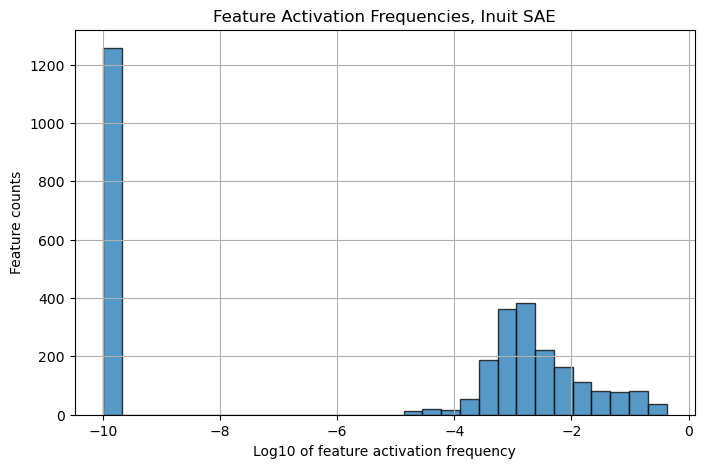

In [46]:
# plot log10 of feature activation frequencies (also called feature density) 
log_frequencies = np.log10(feature_frequencies + 1e-10)  # avoid log 0 

plt.figure(figsize=(8, 5))
plt.hist(log_frequencies, bins=30, edgecolor="black", alpha=0.75)
plt.xlabel("Log10 of feature activation frequency")
plt.ylabel("Feature counts")
plt.title("Feature Activation Frequencies, Inuit SAE")
plt.grid(True)
plt.show()
